# Central Valley Resilience Ecosystem Services Fallowing Model
1. [Business as Usual](#business-as-usual)
2. [Optimized Outcomes](#optimized-outcomes)

In [76]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
sns.set_style("white")

### Read in Data

In [2]:
df = pd.read_csv('../data/data_kern.csv')
df.head()

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,HabCorridors,ConservationAreas,ImpBirdAreas,Nitrate,ModSAGBI,Prox2Wetlands,Depth2GroundWater
0,45,70.791382,AlfalfaandAlfalfaMixtures,78836.822440,359.620220,12283.604020,100.0,100.0,0.0,94.0,0.0,100.0,0.0,0.000000,42.0,0.0,20.0
1,72,81.343317,AlfalfaandAlfalfaMixtures,90587.985160,413.224051,1975.754272,100.0,100.0,100.0,0.0,0.0,100.0,0.0,100.000000,0.0,100.0,5.0
2,91,28.286742,AlfalfaandAlfalfaMixtures,31501.529700,143.696647,3311.302980,100.0,100.0,0.0,0.0,0.0,46.0,91.0,93.333333,98.0,0.0,20.0
3,116,6.073612,AlfalfaandAlfalfaMixtures,6763.878538,30.853951,417.364790,100.0,100.0,0.0,0.0,0.0,100.0,0.0,83.333333,75.5,0.0,11.5
4,143,97.932855,AlfalfaandAlfalfaMixtures,109062.924200,497.498904,11437.290070,100.0,100.0,4.0,0.0,83.0,100.0,0.0,0.000000,97.0,100.0,20.0


#### Compare inputs to PPIC report
|Region|Land <br>(1,000s acres) <br>|Applied Water<br>(1,000s of acre-ft)<br>|Revenue <br>(2010 $, millions)<br>|
|:----:|:-------------:|:-----------------:|:----------------:|
|KR    |827           |2,958              |3,948|
|SE    |1,134         |3,662              |5,930|
|SW    |1,112         |3,177              |3,917|

In [3]:
total_revenue = df['FieldCropPrice'].sum()
print (f'${total_revenue:,.2f} in annual revenue')

$7,298,194,072.79 in annual revenue


In [4]:
cropland = df['Area'].sum()
print(f'{cropland:,.0f} acres of cropland')

856,945 acres of cropland


In [5]:
applied_water = df['SavedWater'].sum()
applied_water_s = (f'{applied_water:,.0f} acre-feet of applied water')

This example {{applied_water_s}} should work

In [6]:
pd.DataFrame({'Region': ['KR'], 'Land':[f'{cropland:,.0f}'], 'Water':[f'{applied_water:,.0f}'], 'Revenue':[f'${total_revenue:,.0f}']})

,Region,Land,Water,Revenue
0,KR,"856,945","2,844,471","$7,298,194,073"


In [7]:
crop_x = pd.read_csv('../data/crop_x.csv')
crop_x.head()

,Crop,Crop_PPIC
0,AlfalfaandAlfalfaMixtures,alfalfa-pasture
1,Almonds,trees-vines
2,Apples,veg-fruits
3,Avocados,veg-fruits
4,Beans(Dry),field-crops-grains


In [8]:
targets = pd.read_csv('../data/targets.csv', index_col='region', thousands=',')
targets

,alfalfa-pasture,corn,field-crops-grains,veg-fruits,trees-vines
region,,,,,
NW,21320.0,8400.0,85920.0,3880.0,3880.0
NE,56850.0,7750.0,23580.0,2260.0,16800.0
SW,36820.0,3880.0,72350.0,8400.0,7750.0
SE,38760.0,16150.0,124030.0,650.0,9690.0
KR,88500.0,54910.0,42640.0,3230.0,11630.0


### Set Up Analysis
#### Cross-walk crop type to PPIC crop type

In [9]:
df = df.join(crop_x.set_index('Crop'), on='Crop')

#### Calculate PricePerAcre column
Will be used to sort crop types within each PPIC crop type to select lowest revenue crops first when fallowing fields

In [10]:
df['PricePerAcre'] = round(df['FieldCropPrice'] / df['Area'],2)

#### Normalize SavedWater, Recharge, and Depth2Groundwater

In [11]:
norm_columns = ['SavedWater', 'Recharge', 'Depth2GroundWater']
for column in norm_columns:
    new_col = str(column + '_Norm')
    df[new_col] = df[column] / df[column].max() * 100
df.head()

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,...,ImpBirdAreas,Nitrate,ModSAGBI,Prox2Wetlands,Depth2GroundWater,Crop_PPIC,PricePerAcre,SavedWater_Norm,Recharge_Norm,Depth2GroundWater_Norm
0,45,70.791382,AlfalfaandAlfalfaMixtures,78836.822440,359.620220,12283.604020,100.0,100.0,0.0,94.0,...,0.0,0.000000,42.0,0.0,20.0,alfalfa-pasture,1113.65,17.043398,15.554193,100.0
1,72,81.343317,AlfalfaandAlfalfaMixtures,90587.985160,413.224051,1975.754272,100.0,100.0,100.0,0.0,...,0.0,100.000000,0.0,100.0,5.0,alfalfa-pasture,1113.65,19.583832,2.501812,25.0
2,91,28.286742,AlfalfaandAlfalfaMixtures,31501.529700,143.696647,3311.302980,100.0,100.0,0.0,0.0,...,91.0,93.333333,98.0,0.0,20.0,alfalfa-pasture,1113.65,6.810182,4.192959,100.0
3,116,6.073612,AlfalfaandAlfalfaMixtures,6763.878538,30.853951,417.364790,100.0,100.0,0.0,0.0,...,0.0,83.333333,75.5,0.0,11.5,alfalfa-pasture,1113.65,1.462254,0.528491,57.5
4,143,97.932855,AlfalfaandAlfalfaMixtures,109062.924200,497.498904,11437.290070,100.0,100.0,4.0,0.0,...,0.0,0.000000,97.0,100.0,20.0,alfalfa-pasture,1113.65,23.577851,14.482542,100.0


#### Calculate area-weighted ecosystem service values

In [12]:
df.columns

Index(['FID', 'Area', 'Crop', 'FieldCropPrice', 'SavedWater', 'Recharge',
       'Kitfox', 'TiptonKRat', 'GiantGarterSnake', 'TNC', 'HabCorridors',
       'ConservationAreas', 'ImpBirdAreas', 'Nitrate', 'ModSAGBI',
       'Prox2Wetlands', 'Depth2GroundWater', 'Crop_PPIC', 'PricePerAcre',
       'SavedWater_Norm', 'Recharge_Norm', 'Depth2GroundWater_Norm'],
      dtype='object')

In [13]:
# eco_service_columns = [str(c) for c in df.columns[6:16]] + [str(d) for d in df.columns[19:]]
eco_service_columns = np.append(df.columns.values[6:16], df.columns.values[19:])
eco_service_columns

array(['Kitfox', 'TiptonKRat', 'GiantGarterSnake', 'TNC', 'HabCorridors',
       'ConservationAreas', 'ImpBirdAreas', 'Nitrate', 'ModSAGBI',
       'Prox2Wetlands', 'SavedWater_Norm', 'Recharge_Norm',
       'Depth2GroundWater_Norm'], dtype=object)

In [14]:
for eco_service in np.append(eco_service_columns[:-3], eco_service_columns[-1]): # exclude Recharge and Saved Water
    new_col = str(eco_service + '_Total')
    df[new_col] = df[eco_service] / 100 * df['Area']

In [15]:
df.head()

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,...,TiptonKRat_Total,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total
0,45,70.791382,AlfalfaandAlfalfaMixtures,78836.822440,359.620220,12283.604020,100.0,100.0,0.0,94.0,...,70.791382,0.000000,66.543899,0.00000,70.791382,0.000000,0.000000,29.732380,0.000000,70.791382
1,72,81.343317,AlfalfaandAlfalfaMixtures,90587.985160,413.224051,1975.754272,100.0,100.0,100.0,0.0,...,81.343317,81.343317,0.000000,0.00000,81.343317,0.000000,81.343317,0.000000,81.343317,20.335829
2,91,28.286742,AlfalfaandAlfalfaMixtures,31501.529700,143.696647,3311.302980,100.0,100.0,0.0,0.0,...,28.286742,0.000000,0.000000,0.00000,13.011901,25.740935,26.400959,27.721007,0.000000,28.286742
3,116,6.073612,AlfalfaandAlfalfaMixtures,6763.878538,30.853951,417.364790,100.0,100.0,0.0,0.0,...,6.073612,0.000000,0.000000,0.00000,6.073612,0.000000,5.061344,4.585577,0.000000,3.492327
4,143,97.932855,AlfalfaandAlfalfaMixtures,109062.924200,497.498904,11437.290070,100.0,100.0,4.0,0.0,...,97.932855,3.917314,0.000000,81.28427,97.932855,0.000000,0.000000,94.994870,97.932855,97.932855


TO DO: Need to confirm that measures are not yet area weighted

<a id='business-as-usual'></a>

# Business As Usual

This section of the notebook uses a bootstrap approach to model the distribution of potential ecosystem service outcomes (i.e., amount of ecosystem services acquired as fields are fallowed) that can be expected with the amount of fallowing required to meet SGMA targets per region, as defined by [Medellin-Azuara, Josue et al. (2019). Water and the Future of the San Joaquin Valley, Technical Appendix C: Potential Economic Impacts of Reducing Water Use on San Joaquin Valley Agriculture. Public Policy Insitute of California.](https://www.ppic.org/publication/water-and-the-future-of-the-san-joaquin-valley/)

Results are saved in tabular format for the region evaluated in the outputs/ directory of this project folder.  

### Model Business as Usual Case

In [16]:
df.columns

Index(['FID', 'Area', 'Crop', 'FieldCropPrice', 'SavedWater', 'Recharge',
       'Kitfox', 'TiptonKRat', 'GiantGarterSnake', 'TNC', 'HabCorridors',
       'ConservationAreas', 'ImpBirdAreas', 'Nitrate', 'ModSAGBI',
       'Prox2Wetlands', 'Depth2GroundWater', 'Crop_PPIC', 'PricePerAcre',
       'SavedWater_Norm', 'Recharge_Norm', 'Depth2GroundWater_Norm',
       'Kitfox_Total', 'TiptonKRat_Total', 'GiantGarterSnake_Total',
       'TNC_Total', 'HabCorridors_Total', 'ConservationAreas_Total',
       'ImpBirdAreas_Total', 'Nitrate_Total', 'ModSAGBI_Total',
       'Prox2Wetlands_Total', 'Depth2GroundWater_Norm_Total'],
      dtype='object')

In [17]:
#Get list of columns to track for each repetition
outcome_cols = ['Area', 'FieldCropPrice', 'SavedWater_Norm', 'Recharge_Norm', 'Kitfox_Total',
                'TiptonKRat_Total', 'GiantGarterSnake_Total', 'TNC_Total', 'HabCorridors_Total',
                'ConservationAreas_Total', 'ImpBirdAreas_Total', 'Nitrate_Total', 'ModSAGBI_Total',
                'Prox2Wetlands_Total', 'Depth2GroundWater_Norm_Total'] 

In [18]:
# specify region, list of crop types, and list of ecosystem service outcomes to track
# set up dataframe to store outcomes of each trial
# for 1000 tries:
#    set up master df (shape = 0 x number of columns of df)
#    for crop in crop type:
#        subset dataset, get target, check that sufficient area is available
#        randomly sort the df
#        subset to meet target
#        append to master df
#    calculate total ecosystem services accumulated and acres faLLowed in master df
#    append outcomes to trials dataframe

region = 'KR'
crop_types = targets.columns
trials = pd.DataFrame(columns=outcome_cols)

for i in range(100):
    df_fallow = pd.DataFrame(columns=df.columns)
    for crop in crop_types:
        df_crop = df[df['Crop_PPIC'] == crop]
        target = targets.loc[region, crop]
        df_crop_shuffle = df_crop.sample(n=df_crop.shape[0])
        df_crop_shuffle.sort_values('PricePerAcre', inplace=True)
        # Identify fields up to target
        df_fallow_bool = df_crop_shuffle['Area'].cumsum() < target
        # Get one additional field by updating value from False to True where 
        # first instance of False is located
        if not df_fallow_bool[df_fallow_bool!=True].empty:
            index = df_fallow_bool[df_fallow_bool!=True].index[0]
            df_fallow_bool.at[index]=True        
        df_crop_fallow = df_crop_shuffle[df_fallow_bool]
        df_fallow = df_fallow.append(df_crop_fallow, ignore_index=True)
    outcomes = pd.DataFrame(df_fallow[outcome_cols].sum()).T
    areas = df_fallow[['Area','Crop_PPIC']].groupby('Crop_PPIC').sum().T
    areas.reset_index(drop=True, inplace=True)
    output = pd.concat([outcomes, areas], axis=1, sort=False)
    trials = trials.append(output, ignore_index=True, sort=False)

In [19]:
trials.head(10)

,Area,FieldCropPrice,SavedWater_Norm,Recharge_Norm,Kitfox_Total,TiptonKRat_Total,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total,alfalfa-pasture,corn,field-crops-grains,trees-vines,veg-fruits
0,162065.919083,2.650315e+08,29024.137411,18085.931601,161919.133108,142827.922140,54022.798948,26870.747241,4739.073339,110612.455695,34145.979193,122803.580820,65684.147573,90900.528473,121423.579083,80767.856997,23740.216326,42643.380744,11632.370817,3282.094201
1,162068.241712,2.649480e+08,29028.691090,18123.722303,161921.455736,141735.241718,53157.141361,26042.078191,4213.620704,110676.410884,33873.021565,123148.766371,65968.381307,89914.653634,121667.946651,80767.856997,23740.216326,42643.684706,11679.365379,3237.118305
2,162071.691704,2.649599e+08,29024.379744,18120.848802,161924.905729,143112.486037,53157.907883,26989.568391,4286.430456,111135.804413,34283.819886,122400.290887,65498.902044,90787.989249,121114.374673,80767.856997,23740.216326,42659.483355,11633.530717,3270.604310
3,162046.722687,2.647510e+08,29022.208726,18071.764208,161899.936711,142683.336146,53254.854873,26276.916414,4670.709586,110479.151987,33625.026328,122348.140620,65954.097147,89894.075737,121511.407410,80767.856997,23740.216326,42657.513777,11642.964508,3238.171080
4,162092.139616,2.650822e+08,29032.381780,18076.399940,161945.353640,143655.045651,53555.536319,26872.193547,4402.085338,110013.860947,33933.599822,122593.711425,65204.344433,90795.836249,121484.386937,80767.856997,23740.216326,42649.034120,11689.431825,3245.600348
5,162084.075586,2.650087e+08,29027.223163,18171.852919,161937.289610,144252.411905,54748.600145,26545.777525,4533.990508,111284.233771,33983.249969,122598.322722,65493.107904,91683.821969,121273.217026,80767.856997,23740.216326,42662.126333,11648.926444,3264.949486
6,162159.893153,2.651514e+08,29040.538782,18132.311678,162013.107177,142771.389302,52951.146486,26413.210066,4556.793470,110096.791292,33539.341922,123002.119765,66113.447659,90096.483197,121785.824413,80767.856997,23740.216326,42709.573209,11710.583047,3231.663574
7,162118.218465,2.651001e+08,29030.170056,18077.530241,161971.432489,142331.360246,53946.328255,26325.701979,4240.397313,110506.604311,34092.637618,122921.722813,65478.064739,91864.824929,121432.195794,80767.856997,23740.216326,42688.995121,11645.356734,3275.793287
8,162072.316325,2.647336e+08,29023.908666,18107.236187,161925.530350,142347.276216,53651.398861,26470.139221,4515.064334,110010.832510,34095.680317,122616.588284,65605.466814,90842.682569,121603.538922,80767.856997,23740.216326,42689.819785,11639.509522,3234.913696
9,162202.192259,2.653734e+08,29040.589713,18169.136730,162055.406284,142383.447072,54251.079203,26728.951037,4245.972938,110212.257491,33476.695795,122922.746886,64296.053891,90704.708923,121649.466469,80767.856997,23740.216326,42739.849245,11665.406376,3288.863316


#### Save output

In [20]:
outname = '../outputs/' + 'trials' + region +'.csv'
trials.to_csv(outname)

### Visualize results

#### Compare to PPIC Report

In [21]:
# Average revenue loss
value = trials['FieldCropPrice'].mean()
print (f'${value:,.2f}')

$265,064,585.32


#### Ensure sufficient acreage fallowed

In [22]:
# Bar chart with each crop type on x-axis, acreage fallowed as bars, and targets as dots. Visualize difference between
# acreage fallowed and target for each crop type in one chart.

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


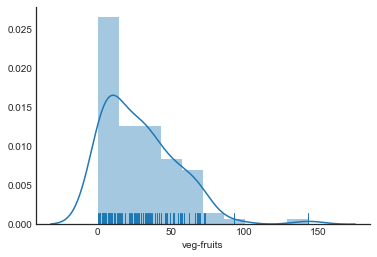

In [23]:
crop_type = 'veg-fruits'
sns.distplot(trials[crop_type]-targets.loc[region, crop_type], rug=True)
sns.despine()

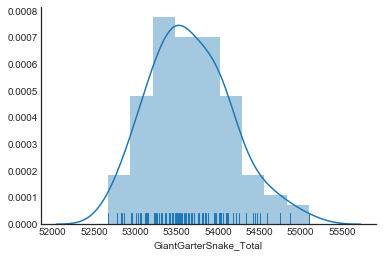

In [24]:
sns.distplot(trials['GiantGarterSnake_Total'], rug=True)
sns.despine()

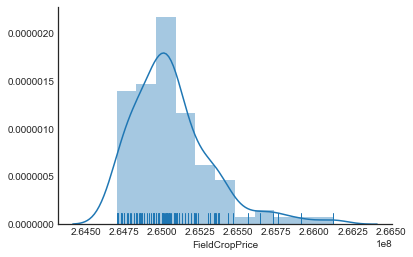

In [25]:
sns.distplot(trials['FieldCropPrice'], rug=True)
sns.despine()

<a id='optimized-outcomes'></a>

# Optimized Outcomes


This section of the notebook calculates the optimal outcome for ecosystem services produced by fallowed land to meet SGMA targets by ranking parcels within each crop type by a weighted average ecosystem services metric and selecting the top ranked parcels by crop type to meet fallowing targets set by the [PPIC.](https://www.ppic.org/publication/water-and-the-future-of-the-san-joaquin-valley/) 

Weights may be adjusted before running the notebook. By default, all ecosystem services are equally weighted.

In [26]:
df.head()

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,...,TiptonKRat_Total,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total
0,45,70.791382,AlfalfaandAlfalfaMixtures,78836.822440,359.620220,12283.604020,100.0,100.0,0.0,94.0,...,70.791382,0.000000,66.543899,0.00000,70.791382,0.000000,0.000000,29.732380,0.000000,70.791382
1,72,81.343317,AlfalfaandAlfalfaMixtures,90587.985160,413.224051,1975.754272,100.0,100.0,100.0,0.0,...,81.343317,81.343317,0.000000,0.00000,81.343317,0.000000,81.343317,0.000000,81.343317,20.335829
2,91,28.286742,AlfalfaandAlfalfaMixtures,31501.529700,143.696647,3311.302980,100.0,100.0,0.0,0.0,...,28.286742,0.000000,0.000000,0.00000,13.011901,25.740935,26.400959,27.721007,0.000000,28.286742
3,116,6.073612,AlfalfaandAlfalfaMixtures,6763.878538,30.853951,417.364790,100.0,100.0,0.0,0.0,...,6.073612,0.000000,0.000000,0.00000,6.073612,0.000000,5.061344,4.585577,0.000000,3.492327
4,143,97.932855,AlfalfaandAlfalfaMixtures,109062.924200,497.498904,11437.290070,100.0,100.0,4.0,0.0,...,97.932855,3.917314,0.000000,81.28427,97.932855,0.000000,0.000000,94.994870,97.932855,97.932855


In [27]:
eco_services = ['SavedWater_Norm', 'Recharge_Norm', 'Kitfox',
                'TiptonKRat', 'GiantGarterSnake', 'TNC', 'HabCorridors',
                'ConservationAreas', 'ImpBirdAreas', 'Nitrate', 'ModSAGBI',
                'Prox2Wetlands', 'Depth2GroundWater_Norm']

In [28]:
# Create weights table with equal weights
# weight_vals = [1/len(eco_services)] * len(eco_services)
# out = OrderedDict(list(zip(eco_services, weight_vals)))
# out_df = pd.DataFrame(weight_vals, index = eco_services, columns = ['weights'])
# out_df.to_csv('../data/weights.csv')

In [29]:
weight_table = pd.read_csv('../data/weights.csv', index_col=0)
weight_table

,weights
SavedWater_Norm,0.076923
Recharge_Norm,0.076923
Kitfox,0.076923
TiptonKRat,0.076923
GiantGarterSnake,0.076923
TNC,0.076923
HabCorridors,0.076923
ConservationAreas,0.076923
ImpBirdAreas,0.076923
Nitrate,0.076923


In [30]:
weights = np.array(weight_table['weights'])
weights

array([0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308,
       0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308,
       0.07692308, 0.07692308, 0.07692308])

In [31]:
weights.shape[0] == df[eco_services].shape[1]

True

In [32]:
weight_table.index.values == df[eco_services].columns.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [33]:
df['outcome'] = pd.Series(np.average(df[eco_services], weights=weights, axis=1))
df.head()

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,...,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total,outcome
0,45,70.791382,AlfalfaandAlfalfaMixtures,78836.822440,359.620220,12283.604020,100.0,100.0,0.0,94.0,...,0.000000,66.543899,0.00000,70.791382,0.000000,0.000000,29.732380,0.000000,70.791382,43.738276
1,72,81.343317,AlfalfaandAlfalfaMixtures,90587.985160,413.224051,1975.754272,100.0,100.0,100.0,0.0,...,81.343317,0.000000,0.00000,81.343317,0.000000,81.343317,0.000000,81.343317,20.335829,49.775819
2,91,28.286742,AlfalfaandAlfalfaMixtures,31501.529700,143.696647,3311.302980,100.0,100.0,0.0,0.0,...,0.000000,0.000000,0.00000,13.011901,25.740935,26.400959,27.721007,0.000000,28.286742,49.179729
3,116,6.073612,AlfalfaandAlfalfaMixtures,6763.878538,30.853951,417.364790,100.0,100.0,0.0,0.0,...,0.000000,0.000000,0.00000,6.073612,0.000000,5.061344,4.585577,0.000000,3.492327,39.871083
4,143,97.932855,AlfalfaandAlfalfaMixtures,109062.924200,497.498904,11437.290070,100.0,100.0,4.0,0.0,...,3.917314,0.000000,81.28427,97.932855,0.000000,0.000000,94.994870,97.932855,97.932855,55.543107


In [34]:
df_optimal = pd.DataFrame(columns=df.columns)
for crop in crop_types:
    df_crop = df[df['Crop_PPIC'] == crop]
    target = targets.loc[region, crop]
    df_crop_sorted = df_crop.sort_values(['PricePerAcre','outcome'], ascending=[True,False])
    # Identify fields up to target
    df_fallow_bool = df_crop_sorted['Area'].cumsum() < target
    # Get one additional field by updating value from False to True where 
    # first instance of False is located
    if not df_fallow_bool[df_fallow_bool!=True].empty:
        index = df_fallow_bool[df_fallow_bool!=True].index[0]
        df_fallow_bool.at[index]=True        
    df_crop_fallow = df_crop_sorted[df_fallow_bool]
    df_optimal = df_optimal.append(df_crop_fallow, ignore_index=True)
outcomes = pd.DataFrame(df_optimal[outcome_cols].sum()).T
areas = df_optimal[['Area','Crop_PPIC']].groupby('Crop_PPIC').sum().T
areas.reset_index(drop=True, inplace=True)
output = pd.concat([outcomes, areas], axis=1, sort=False)

In [35]:
df_optimal.head(10)

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,...,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total,outcome
0,2974,49.319529,MixedPasture,927.700341,227.363029,1278.293374,100.0,100.0,0.0,100.0,...,0.00000,49.319529,0.000000,49.319529,49.319529,49.319529,38.715830,49.319529,24.659765,64.684155
1,5672,76.002196,MixedPasture,1429.601302,350.370123,2351.678467,100.0,100.0,0.0,100.0,...,0.00000,76.002196,0.000000,76.002196,76.002196,76.002196,47.501372,76.002196,38.001098,64.006372
2,1147,18.954615,MixedPasture,356.536303,87.380774,1302.517872,100.0,100.0,0.0,100.0,...,0.00000,18.954615,0.000000,18.954615,18.954615,18.533401,13.647323,18.954615,9.477307,63.505255
3,6090,33.045659,MixedPasture,621.588841,152.340487,1480.202981,100.0,100.0,41.0,100.0,...,13.54872,33.045659,0.000000,33.045659,33.045659,17.991525,1.817511,33.045659,33.045659,62.310661
4,7798,16.917084,MixedPasture,318.210353,77.987758,1148.184416,100.0,100.0,0.0,100.0,...,0.00000,16.917084,0.000000,16.917084,16.917084,15.789279,12.180301,16.917084,6.343907,62.152560
5,2807,11.906969,MixedPasture,223.970081,54.891126,1396.546932,100.0,0.0,0.0,100.0,...,0.00000,11.906969,11.906969,11.906969,0.000000,11.642369,10.716272,11.906969,11.906969,60.934431
6,17865,7.646042,MixedPasture,143.822056,35.248255,1258.896643,100.0,100.0,0.0,0.0,...,0.00000,0.000000,0.000000,7.034359,0.000000,6.626570,7.416661,7.646042,5.734532,50.302405
7,14446,1.680997,MixedPasture,31.619553,7.749396,276.770829,100.0,100.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.958168,0.000000,1.456864,1.630567,1.680997,1.260748,47.414184
8,14014,3.378447,MixedPasture,63.548587,15.574640,556.250585,100.0,100.0,0.0,0.0,...,0.00000,0.000000,0.000000,3.378447,0.000000,1.876915,1.858146,3.378447,3.378447,47.076772
9,12334,4.145157,MixedPasture,77.970411,19.109176,682.487031,100.0,100.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.566505,0.000000,3.500355,4.020803,4.145157,3.212497,44.183150


In [63]:
df_optimal.to_csv('../outputs/optimal.csv')

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


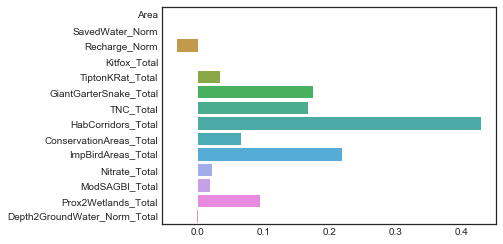

In [36]:
plot_cols = outcome_cols[:1] + outcome_cols[2:] #Exclude FieldCropPrice
optimal = df_optimal[plot_cols].sum()
as_usual = trials[plot_cols].mean()
pct_chg = (optimal - as_usual)/as_usual
sns.barplot(x = pct_chg, y = df_optimal[plot_cols].columns)

In [37]:
optimal_cost = df_optimal['FieldCropPrice'].sum()
print(f'${optimal_cost.sum():,.2f}')

$265,486,230.37


In [38]:
average_cost = trials['FieldCropPrice'].mean()
print(f'${average_cost:,.2f}')

$265,064,585.32


In [39]:
cost = df_optimal['FieldCropPrice'].sum() - trials['FieldCropPrice'].mean()
print (f'The cost of this optimization is ${cost:,.0f}')

The cost of this optimization is $421,645


In [40]:
for crop in crop_types:
    area_diff = df_optimal[df_optimal['Crop_PPIC']==crop]['Area'].sum() - trials[crop].mean()
    print (f'{area_diff:,.2f} acres of {crop}')

-0.00 acres of alfalfa-pasture
0.00 acres of corn
18.43 acres of field-crops-grains
57.63 acres of veg-fruits
-10.63 acres of trees-vines


In [41]:
df.columns

Index(['FID', 'Area', 'Crop', 'FieldCropPrice', 'SavedWater', 'Recharge',
       'Kitfox', 'TiptonKRat', 'GiantGarterSnake', 'TNC', 'HabCorridors',
       'ConservationAreas', 'ImpBirdAreas', 'Nitrate', 'ModSAGBI',
       'Prox2Wetlands', 'Depth2GroundWater', 'Crop_PPIC', 'PricePerAcre',
       'SavedWater_Norm', 'Recharge_Norm', 'Depth2GroundWater_Norm',
       'Kitfox_Total', 'TiptonKRat_Total', 'GiantGarterSnake_Total',
       'TNC_Total', 'HabCorridors_Total', 'ConservationAreas_Total',
       'ImpBirdAreas_Total', 'Nitrate_Total', 'ModSAGBI_Total',
       'Prox2Wetlands_Total', 'Depth2GroundWater_Norm_Total', 'outcome'],
      dtype='object')

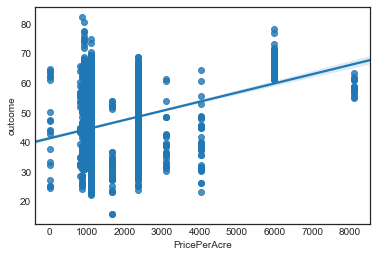

In [42]:
sns.regplot(y=df_optimal['outcome'], x=df_optimal['PricePerAcre'])

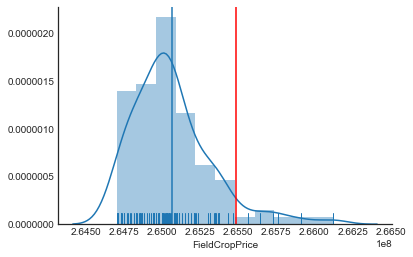

In [43]:
sns.distplot(trials['FieldCropPrice'], rug=True)
plt.axvline(x = df_optimal['FieldCropPrice'].sum(), color='red')
plt.axvline(x = trials['FieldCropPrice'].mean())
sns.despine()

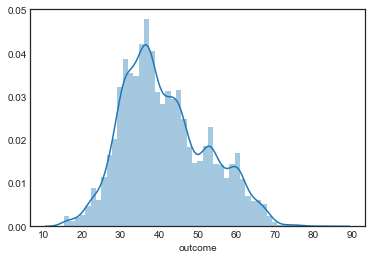

In [44]:
sns.distplot(df.dropna(subset=['outcome'])['outcome'])

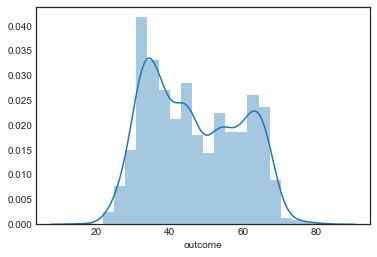

In [45]:
sns.distplot(df_optimal.dropna(subset=['outcome'])['outcome'])

In [46]:
sub_crops = df['Crop'].unique()
sub_crops

array(['AlfalfaandAlfalfaMixtures', 'Almonds', 'Apples', 'Avocados',
       'Beans(Dry)', 'BushBerries', 'Carrots', 'Cherries', 'Citrus',
       'ColeCrops', 'Corn,SorghumandSudan', 'Cotton',
       'Flowers,NurseryandChristmasTreeFarms', 'Grapes', 'Idle', 'Kiwis',
       'Lettuce/LeafyGreens', 'Melons,SquashandCucumbers',
       'MiscellaneousDeciduous', 'MiscellaneousGrainandHay',
       'MiscellaneousGrasses', 'MiscellaneousSubtropicalFruits',
       'MiscellaneousTruckCrops', 'MixedPasture', 'Olives',
       'OnionsandGarlic', 'Peaches/Nectarines', 'Pears', 'Peppers',
       'Pistachios', 'Plums,PrunesandApricots', 'Pomegranates',
       'PotatoesandSweetPotatoes', 'Safflower', 'Strawberries',
       'Tomatoes', 'Walnuts', 'Wheat', 'YoungPerennials'], dtype=object)

In [47]:
len(sub_crops)

39

In [48]:
data = df_optimal[df_optimal['Crop']=='AlfalfaandAlfalfaMixtures']
x = data['PricePerAcre']
y = data['outcome']

In [49]:
df_by_crop = df_optimal.groupby(['Crop']).mean()
df_by_crop

,Area,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,HabCorridors,ConservationAreas,...,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total,outcome
Crop,,,,,,,,,,,,,,,,,,,,,
AlfalfaandAlfalfaMixtures,59.731250,66519.706825,303.434751,4890.834405,100.0,91.839087,26.823721,13.856485,2.948484,70.712023,...,19.800209,9.472087,1.647627,41.982106,14.334714,46.555226,23.221759,33.621886,44.438397,45.442748
Almonds,52.231632,313156.315233,237.131608,4403.566437,100.0,100.000000,90.359223,35.912783,28.838592,99.429612,...,45.710100,18.716872,13.081723,51.900074,33.198350,42.489246,26.273790,51.967401,44.499146,65.140398
Apples,20.140825,33388.452025,73.111193,2217.490898,100.0,10.937500,9.375000,0.000000,0.000000,32.782552,...,5.866978,0.000000,0.000000,9.911534,0.000000,11.426932,1.628798,18.546428,20.140825,31.902143
"Corn,SorghumandSudan",61.503151,145106.229492,208.495682,5569.744025,100.0,88.710276,30.629534,17.879102,0.115285,68.110535,...,24.991581,12.288116,0.010944,38.732476,11.785833,49.977819,25.799243,40.175303,41.224321,44.951928
MiscellaneousGrainandHay,50.058789,42981.477560,93.109348,4206.477943,100.0,84.087156,8.944954,12.036697,7.339450,75.697248,...,7.313996,7.269348,2.713509,32.157959,13.632474,36.326378,16.472467,26.254507,36.323828,41.970011
MiscellaneousGrasses,48.015989,39216.579211,221.353711,2869.417665,100.0,91.566667,33.333333,8.341667,0.000000,93.333333,...,23.878893,6.290628,0.000000,45.495615,8.947979,44.100054,27.159957,32.826872,31.030752,46.271004
MixedPasture,15.354814,288.824051,70.785692,1079.749057,100.0,89.473684,2.157895,31.578947,5.263158,61.429825,...,0.713091,10.849792,0.626683,12.154687,10.223110,13.214129,8.570758,13.526089,9.120978,45.222203
Tomatoes,83.256728,676726.507350,218.132628,3600.497342,100.0,100.000000,85.714286,14.107143,0.000000,100.000000,...,77.893750,5.300236,0.000000,83.256728,16.889410,71.355858,32.717531,82.127210,80.575239,58.827755
Walnuts,33.053359,102372.201709,119.983692,4278.464506,100.0,55.555556,3.703704,7.407407,14.814815,95.148148,...,0.216866,0.476771,0.757983,29.030202,0.000000,12.899885,24.212431,6.129610,33.053359,40.544931


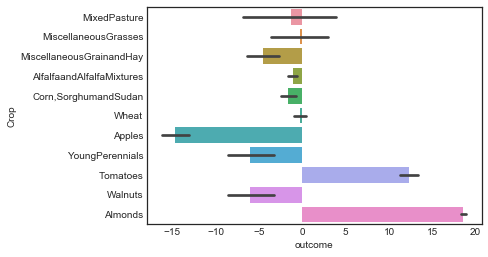

In [50]:
crop_mean_outcome = df_optimal['outcome'].mean()
sns.barplot(data=df_optimal, x='outcome', y='Crop', estimator = (lambda x: np.mean(x)-crop_mean_outcome), ci=90)

In [77]:
import plotly.graph_objects as go
fig =go.figure(data=go.Bar(y=[2,3,1]))
fig.show()

ModuleNotFoundError: No module named 'plotly.graph_objects'

# Mapping

In [78]:
help(folium.TopoJson)

Help on class TopoJson in module folium.features:

class TopoJson(folium.map.Layer)
 |  Creates a TopoJson object for plotting into a Map.
 |  
 |  Parameters
 |  ----------
 |  data: file, dict or str.
 |      The TopoJSON data you want to plot.
 |      * If file, then data will be read in the file and fully
 |      embedded in Leaflet's JavaScript.
 |      * If dict, then data will be converted to JSON and embedded
 |      in the JavaScript.
 |      * If str, then data will be passed to the JavaScript as-is.
 |  object_path: str
 |      The path of the desired object into the TopoJson structure.
 |      Ex: 'objects.myobject'.
 |  style_function: function, default None
 |      A function mapping a TopoJson geometry to a style dict.
 |  name : string, default None
 |      The name of the Layer, as it will appear in LayerControls
 |  overlay : bool, default False
 |      Adds the layer as an optional overlay (True) or the base layer (False).
 |  control : bool, default True
 |      Whe

In [89]:
import os
import json
import requests

fields = 'Kern_Fields.json'
m = folium.Map(location=[35.375951, -118.728828], zoom_start = 9)
folium.TopoJson(open(fields),
                object_path='objects.Kern_Fields',
                name='Kern Fields').add_to(m)
m.save('out_map.html')